In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import pandas as pd
from scipy.optimize import least_squares
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
def exponen(theta, x):
    return theta[0]*np.exp(theta[1]*x)+theta[2]

def log(theta, x):
    return theta[0]*np.log(x + theta[1]) + theta[2]

def inv(theta, x):
    return (theta[0]/(x+theta[1])) + theta[2]

def poly(theta, x, deg):
    out = 0
    for i in range(deg):
        out += theta[i]*(x**(i))
    return out

def lin(theta,x):
    return theta[0]*x + theta[1]

def resid_exp(theta,x,y):
    return y-exponen(theta,x)

def resid_log(theta, x, y):
    return y-log(theta,x)

def resid_inv(theta, x, y):
    return y-inv(theta,x)

def resid_lin(theta, x, y):
    return y-lin(theta,x)

def resid_poly(theta, x, deg, y):
    return y-poly(theta,x,deg)

In [3]:
def testIntensity(src):
    margin = 5
    controlToTest = 100
    scan = 10
    refScan = 10
    lineWidth = 6
    src = cv2.cvtColor(src, cv2.COLOR_RGB2GRAY)
    img = cv2.rotate(src, cv2.ROTATE_90_COUNTERCLOCKWISE)
    
    h,w = img.shape
    
    img = img[margin:h-margin, margin:w-margin]
    
    h,w = img.shape
    
    mean = np.median(img,axis=0)
    mean = 255 - mean

    controlToTest = int(w/3)
    
    if controlToTest < 100:
        controlToTest = 100
    
    left=0
    right=int(w/2)
    
    LFAControl = mean[left:right]
    if(len(LFAControl)==0):
        return 0
    ControlLineLoc = np.argmax(LFAControl)
    
    
    while(ControlLineLoc == left):
        left += margin
        LFAControl = mean[left:right]
        ControlLineLoc = left + np.argmax(LFAControl)
        
    while(ControlLineLoc == right):
        right -= margin
        LFAControl = mean[left:right]
        ControlLineLoc = left + np.argmax(LFAControl)
        
    TestLineLoc = ControlLineLoc + controlToTest
    
    if TestLineLoc > len(mean):
        TestLineLoc = ControlLineLoc + 75
    if TestLineLoc + scan > len(mean):
        scan = len(mean)-TestLineLoc
    
    TestLineLocation = TestLineLoc-scan + np.argmax(mean[TestLineLoc-scan:TestLineLoc+scan])
    
    ReferenceLocation = int((ControlLineLoc + TestLineLocation)/2)
    Reference = np.mean(mean[ReferenceLocation-refScan:ReferenceLocation+refScan])
    
    LFACorrected = mean-Reference
    LFACorrected[LFACorrected < 0] = 0
    
    ControlLine = np.sum(LFACorrected[ControlLineLoc-lineWidth:ControlLineLoc+lineWidth])
    
    TestLine = np.sum(LFACorrected[TestLineLocation-lineWidth:TestLineLocation+lineWidth])
    
    return TestLine/ControlLine

In [4]:
dir = 'demo_data'
index_path = 'demo_index.csv'
test_name = 'LFATest'

In [5]:
index = pd.read_csv(index_path)
SIZE = len(index)

In [10]:
conc = np.zeros(SIZE)
intensities = np.zeros(SIZE)
error = np.zeros(5)
param = ['','','','','']

i=0
for filename in os.listdir(dir):
    f = os.path.join(dir, filename)
    img = cv2.imread(f)
    intensities[i] = testIntensity(img)
    conc[i] = (index.loc[index['File Name'] == filename]).values[0,0]
    i += 1
    
min_conc = np.min(conc)
max_conc = np.max(conc)

x_conc = np.linspace(min_conc,max_conc)

Text(0.5, 1.0, 'Exponential Model')

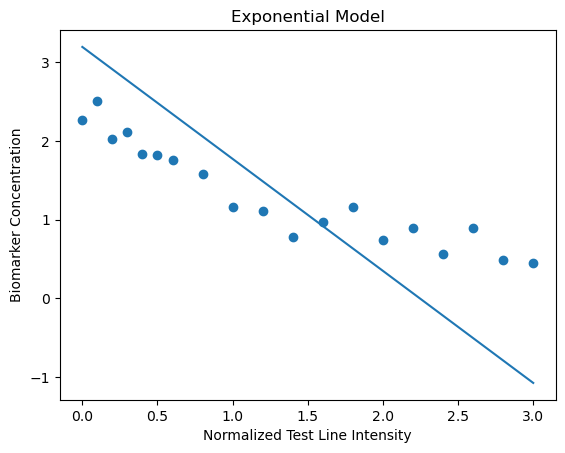

In [12]:
x0 = [1,1,1]
res_exp = least_squares(resid_exp, x0, args=(intensities, conc))
error[0] = mean_squared_error(conc, exponen(res_exp.x,intensities), squared=False)
param[0] = res_exp.x

model = exponen(res_exp.x,x_conc)

plt.plot(x_conc, model, label='Fitted Curve')
plt.scatter(conc,intensities, label='Data')
plt.ylabel("Biomarker Concentration")
plt.xlabel("Normalized Test Line Intensity")
plt.title('Exponential Model')

C:\Users\rohan\AppData\Local\Temp\ipykernel_3820\804785616.py:5: RuntimeWarning: invalid value encountered in log
  return theta[0]*np.log(x + theta[1]) + theta[2]


Text(0.5, 1.0, 'Logarithmic Model')

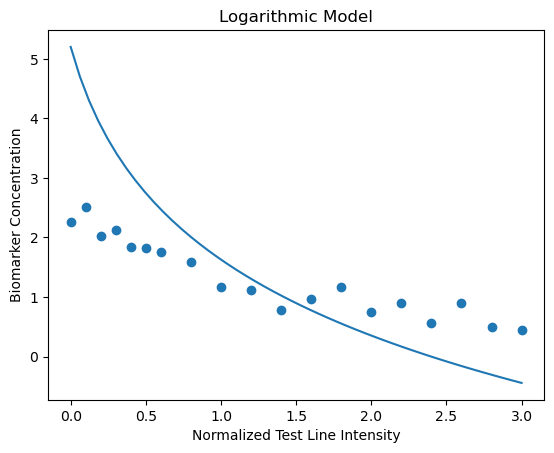

In [13]:
x0 = [1,1,1]
res_log = least_squares(resid_log, x0, args=(intensities, conc))
error[1] = mean_squared_error(conc, log(res_log.x,intensities), squared=False)
param[1] = res_log.x

model = log(res_log.x,x_conc)

plt.plot(x_conc, model, label='Fitted Curve')
plt.scatter(conc,intensities, label='Data')
plt.ylabel("Biomarker Concentration")
plt.xlabel("Normalized Test Line Intensity")
plt.title('Logarithmic Model')

Text(0.5, 1.0, 'Inverse Model')

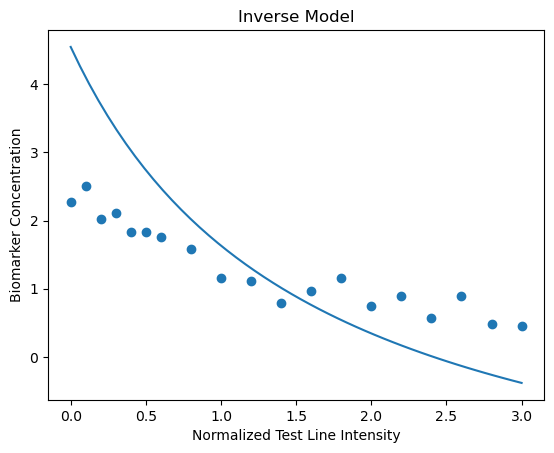

In [14]:
x0 = [1,1,1]
res_inv = least_squares(resid_inv, x0, args=(intensities, conc))
error[2] = mean_squared_error(conc, inv(res_inv.x,intensities), squared=False)
param[2] = res_inv.x

model = inv(res_inv.x,x_conc)

plt.plot(x_conc, model, label='Fitted Curve')
plt.scatter(conc,intensities, label='Data')
plt.ylabel("Biomarker Concentration")
plt.xlabel("Normalized Test Line Intensity")
plt.title('Inverse Model')

Text(0.5, 1.0, 'Linear Model')

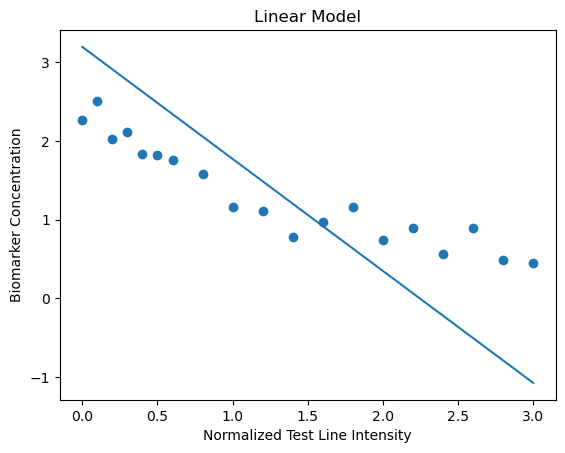

In [15]:
x0 = [1,1]
res_lin = least_squares(resid_lin, x0, args=(intensities, conc))
error[3] = mean_squared_error(conc, lin(res_lin.x,intensities), squared=False)
param[3] = res_lin.x

model = lin(res_lin.x,x_conc)

plt.plot(x_conc, model, label='Fitted Curve')
plt.scatter(conc,intensities, label='Data')
plt.ylabel("Biomarker Concentration")
plt.xlabel("Normalized Test Line Intensity")
plt.title('Linear Model')

Text(0.5, 1.0, 'Quadratic Model')

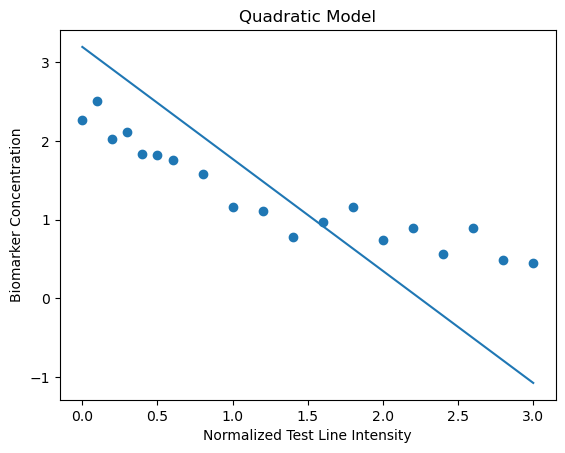

In [16]:
x0 = [1,1,1]
res_quad = least_squares(resid_poly, x0, args=(intensities, 2, conc))
error[4] = mean_squared_error(conc, poly(res_quad.x,intensities, 2), squared=False)
param[4] = res_quad.x

model = poly(res_quad.x,x_conc,2)

plt.plot(x_conc, model, label='Fitted Curve')
plt.scatter(conc,intensities, label='Data')
plt.ylabel("Biomarker Concentration")
plt.xlabel("Normalized Test Line Intensity")
plt.title('Quadratic Model')

In [19]:
models = ['exponential', 'logarithmic', 'inverse', 'linear', 'quadratic']
min_i = np.argmin(error)

path = r'test_parameters/' + test_name + '.txt'

f = open(path, 'w+')
f.write('Test Name: ' + test_name + '\n')
f.write('Model Type: ' + models[min_i] + '\n')
f.write('Parameters: ' + str(param[min_i]))
f.close()

print('Test Name: ' + test_name)
print('Model Type: ' + models[min_i])
print('Parameters: ' + str(param[min_i]))

Test Name: LFATest
Model Type: inverse
Parameters: [11.91541376  1.58341718 -2.9797188 ]
